In [1]:
from math import factorial
import numpy as np 
from matplotlib import pyplot as plt 
from scipy.optimize import newton
from math import sqrt as squareroot, log

In [32]:
fact = lambda x : factorial(int(x))
sqrt = lambda x : squareroot(abs(x))*np.sign(x)

In [3]:
F1 = lambda j1, j2, j3, m1, m2, m3 : sqrt(fact(j1+j2-j3)*fact(j3+j1-j2)*fact(j2+j3-j1)*(2*j3+1)/fact(j1+j2+j3+1))
F2 = lambda j1, j2, j3, m1, m2, m3 : sqrt(fact(j3+m3)*fact(j3-m3)*fact(j2+m2)*fact(j2-m2)*fact(j1+m1)*fact(j1-m1))
def F3(j1, j2, j3, m1, m2, m3):
    smax = min(j1-m1, j2+m2, j1+j2-j3)
    smin = abs(min(min(j3-j2+m1, j3-j1-m2), 0))
    ans = 0
    for s in np.arange(smin, smax+1):
        ans += (-1)**s/(fact(j1-m1-s)*fact(j2+m2-s)*fact(j3-j2+m1+s)*fact(j3-j1-m2+s)*fact(j1+j2-j3-s)*fact(s))
    return ans

def CG(j1, j2, j3, m1, m2, m3) : 
    if not m1+m2==m3 : return 0 
    if abs(m1) > j1 or abs(m2) > j2 or abs(m3) > j3 : return 0 
    if j3 > j1+j2 or j3< abs(j1-j2) : return 0 
    else : return F1(j1, j2, j3, m1, m2, m3)*F2(j1, j2, j3, m1, m2, m3)*F3(j1, j2, j3, m1, m2, m3)

In [4]:
delta = lambda x, y : int(x==y)

In [5]:
A = 80
kappa = 0.05 
mu = [0, 0, 0, 0.35, 0.625, 0.63, 0.448, 0.434]
fdelta = lambda delta: ((1+(2/3)*delta)**2*(1-(4/3)*delta))**(-1/6) 
hw0 = 1
hw00_func = lambda delta : hw0/fdelta(delta)
C_func = lambda hw : -2*kappa*hw
D_func = lambda C : [C*m/2 for m in mu]

#hw00 = 41*A**(-1/3)
#hw0 = lambda delta: hw00*fdelta(delta) 
#C = -2*kappa*hw00 
#D = [C*m/2 for m in mu]

In [6]:
def shell_basis(N, omega):
    if omega-0.5>N : raise Exception("Omega exceeds N+0.5")
    basis_set = [] 
    for l in range(N, -1, -2):
        for lam in range(-l, l+1):
            sigma = omega - lam 
            if sigma==.5 or sigma ==-.5 : 
                basis_set.append([l, lam, sigma]) 
    return basis_set

In [7]:
def hamiltonian(N, omega, deltaf):
    hw00 = hw00_func(deltaf) 
    C = C_func(hw00) 
    D = D_func(C)
    basis = shell_basis(N, omega) 
    dim = len(basis)
    H = np.zeros((dim, dim))
    for i, a in enumerate(basis): 
        for j, b in enumerate(basis): 
            la, lb = a[0], b[0] 
            lama, lamb = a[1], b[1] 
            siga, sigb = a[2], b[2]
            if i==j: H[i, j] += hw0*(N+1.5) + D[N]*la*(la+1) + hw0*
            H[i, j]+= C*(.5*sqrt((la-lamb)*(la+lamb+1))*delta(lama, lamb+1)*delta(siga, sigb-1)+\
                .5*sqrt((la+lamb)*(la-lamb+1))*delta(lama, lamb-1)*delta(siga, sigb+1)+\
                    lama*siga*delta(lama, lamb)*delta(siga, sigb))*delta(la, lb)
            ex_r2 = sqrt((N-lb+2)*(N+lb+1))*delta(la, lb-2) + sqrt((N-lb)*(N+lb+3))*delta(la, lb+2) + (N+1.5)*delta(la, lb)
            ex_Y = sqrt((2*lb+1)/(2*la+1))*CG(lb, 2, la, lamb, 0, lama)*CG(lb, 2, la, 0, 0, 0) 
            H[i, j] += -deltaf*hw0*(2/3)*ex_r2*ex_Y*delta(lama, lamb)*delta(siga,sigb) 
    return H 


In [23]:
N_max = 7
Np = 40 
temps = np.arange(0.5, 5.5, .5) 

In [64]:
def energies(N_max, deltaf=0.2):
    Es = []
    for N in range(N_max+1): 
        for o in range(N+1):
            omega = o+0.5 
            H = hamiltonian(N, omega, deltaf) 
            E = np.linalg.eigvalsh(H)
            Es.extend(E) 
    return np.array(sorted(Es))

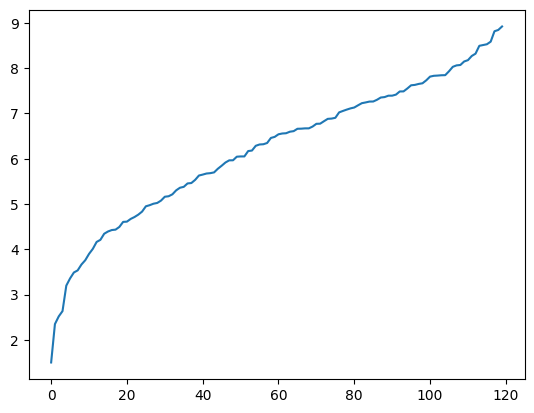

In [46]:
plt.plot(sorted(energies(N_max)))

In [55]:
fd = lambda E, lam, kT : 1/(1+np.exp((E-lam)/kT))
def conservation(lam, Es, kT, Np): 
    return Np/2 - np.sum(fd(Es, lam, kT))
Ef = lambda Es, kT, Np : newton(conservation, x0 = 4, args=(Es, kT, Np))

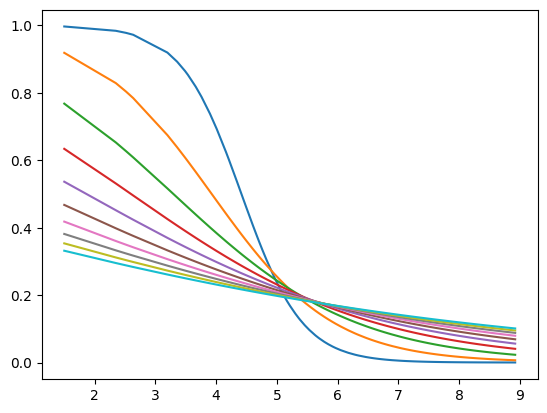

In [67]:
for kT in temps : 
    Es = energies(N_max)
    lam = Ef(Es, kT, Np) 
    ni = fd(Es, lam, kT) 
    plt.plot(Es, ni)
plt.show()

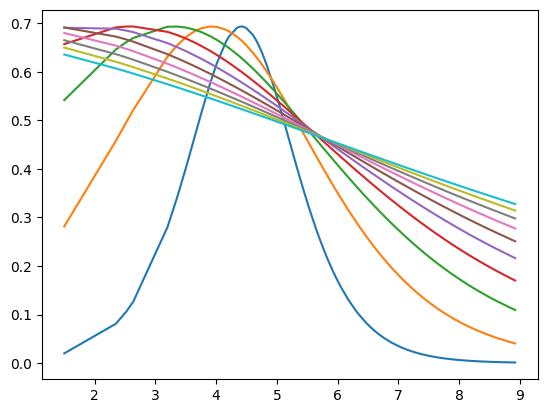

In [71]:
for kT in temps : 
    Es = energies(N_max)
    lam = Ef(Es, kT, Np) 
    ni = fd(Es, lam, kT) 
    si = -ni*np.log(ni) - (1-ni)*np.log(1-ni)
    plt.plot(Es, si)
plt.show()

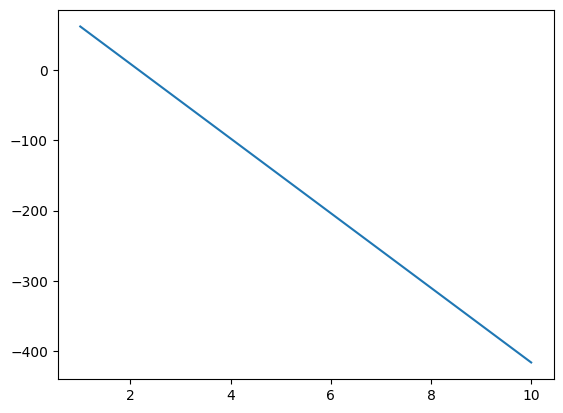

In [75]:
F = []
Ts = np.linspace(1,10,100)
for T in Ts: 
    Es = energies(N_max)
    lam = Ef(Es, kT, Np) 
    ni = fd(Es, lam, kT) 
    si = -ni*np.log(ni) - (1-ni)*np.log(1-ni)
    S = np.sum(si) 
    ET = np.sum(Es*ni)
    F.append(ET-T*S)
plt.plot(Ts, F)
plt.show()